In [1]:
from mcbj import *
import filter_traces
import plots

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

date = "22_02_03"
sample_rate = 50_000
# home_folder = Path(f"D:/BJ_Data/{date}")
home_folder = Path(f"//DATACENTER/BreakJunction_group/BJ_Data/{date}")

# I(V) measurements

## Details

**bias waveform**: *custom_IV_mcbj_with_wait.ini*

**IV bias range**: $\pm 1\;\text{V}$

added 500 ms long 100 mV wait in the beginning to account for relaxation

## 16101-49000    rate=3

In [2]:
total_num = 49000-19500
print(total_num)

29500


### Filtering traces that did not break during the hold measurement

In [3]:
# did_not_break_pull, did_not_break_push = filter_traces.filter_hold(home_folder,
#                                                                    filter_condition=filter_traces.does_not_break_array,
#                                                                    start_trace=19_501, end_trace=49_100,
#                                                                    bias_offset=0, r_serial_ohm=100_000,
#                                                                    min_step_len=20_000)

# with open(home_folder.joinpath('results/did_not_break_pull.npy'), 'wb') as f:
#     np.save(f, did_not_break_pull)
    
# with open(home_folder.joinpath('results/did_not_break_push.npy'), 'wb') as f:
#     np.save(f, did_not_break_push)

In [4]:
with open(home_folder.joinpath('results/did_not_break_pull.npy'), 'rb') as f:
    did_not_break_pull = np.load(f)
    
with open(home_folder.joinpath('results/did_not_break_push.npy'), 'rb') as f:
    did_not_break_push = np.load(f)

In [5]:
print(f'pull: {len(did_not_break_pull)}, {len(did_not_break_pull)/total_num*100}%')
print(f'push: {len(did_not_break_push)}, {len(did_not_break_push)/total_num*100}%')

pull: 12880, 43.66101694915254%
push: 21335, 72.32203389830508%


### Filtering traces where the conductance on the two 200 mV bias plateaus do not differ more than a factor of 2

In [6]:
# stable_pull, _ = filter_traces.filter_hold(home_folder, filter_condition=filter_traces.conductances_close,
#                                            traces=did_not_break_pull,
#                                            bias_offset=0, r_serial_ohm=100_000,
#                                            min_step_len=20_000, max_ratio=2, plateaus=(0, 2))

# _, stable_push = filter_traces.filter_hold(home_folder, filter_condition=filter_traces.conductances_close,
#                                            traces=did_not_break_push,
#                                            bias_offset=0, r_serial_ohm=100_000,
#                                            min_step_len=20_000, max_ratio=2, plateaus=(0, 2))

# with open(home_folder.joinpath('results/stable_pull.npy'), 'wb') as f:
#     np.save(f, stable_pull)
    
# with open(home_folder.joinpath('results/stable_push.npy'), 'wb') as f:
#     np.save(f, stable_push)

In [7]:
with open(home_folder.joinpath('results/stable_pull.npy'), 'rb') as f:
    stable_pull = np.load(f)
    
with open(home_folder.joinpath('results/stable_push.npy'), 'rb') as f:
    stable_push = np.load(f)

In [8]:
print(f'pull: {len(stable_pull)}, {len(stable_pull)/total_num*100}%')
print(f'push: {len(stable_push)}, {len(stable_push)/total_num*100}%')

pull: 8127, 27.54915254237288%
push: 21053, 71.36610169491526%


We are interested in the I(V) curves where the up-down sweeps overlap nicely. The difference between the up-down sweeps is calculated with the function `filter_traces.iv_difference`

### Filtering traces where the up-down I(V) sweeps overlap

0.4974251800322395


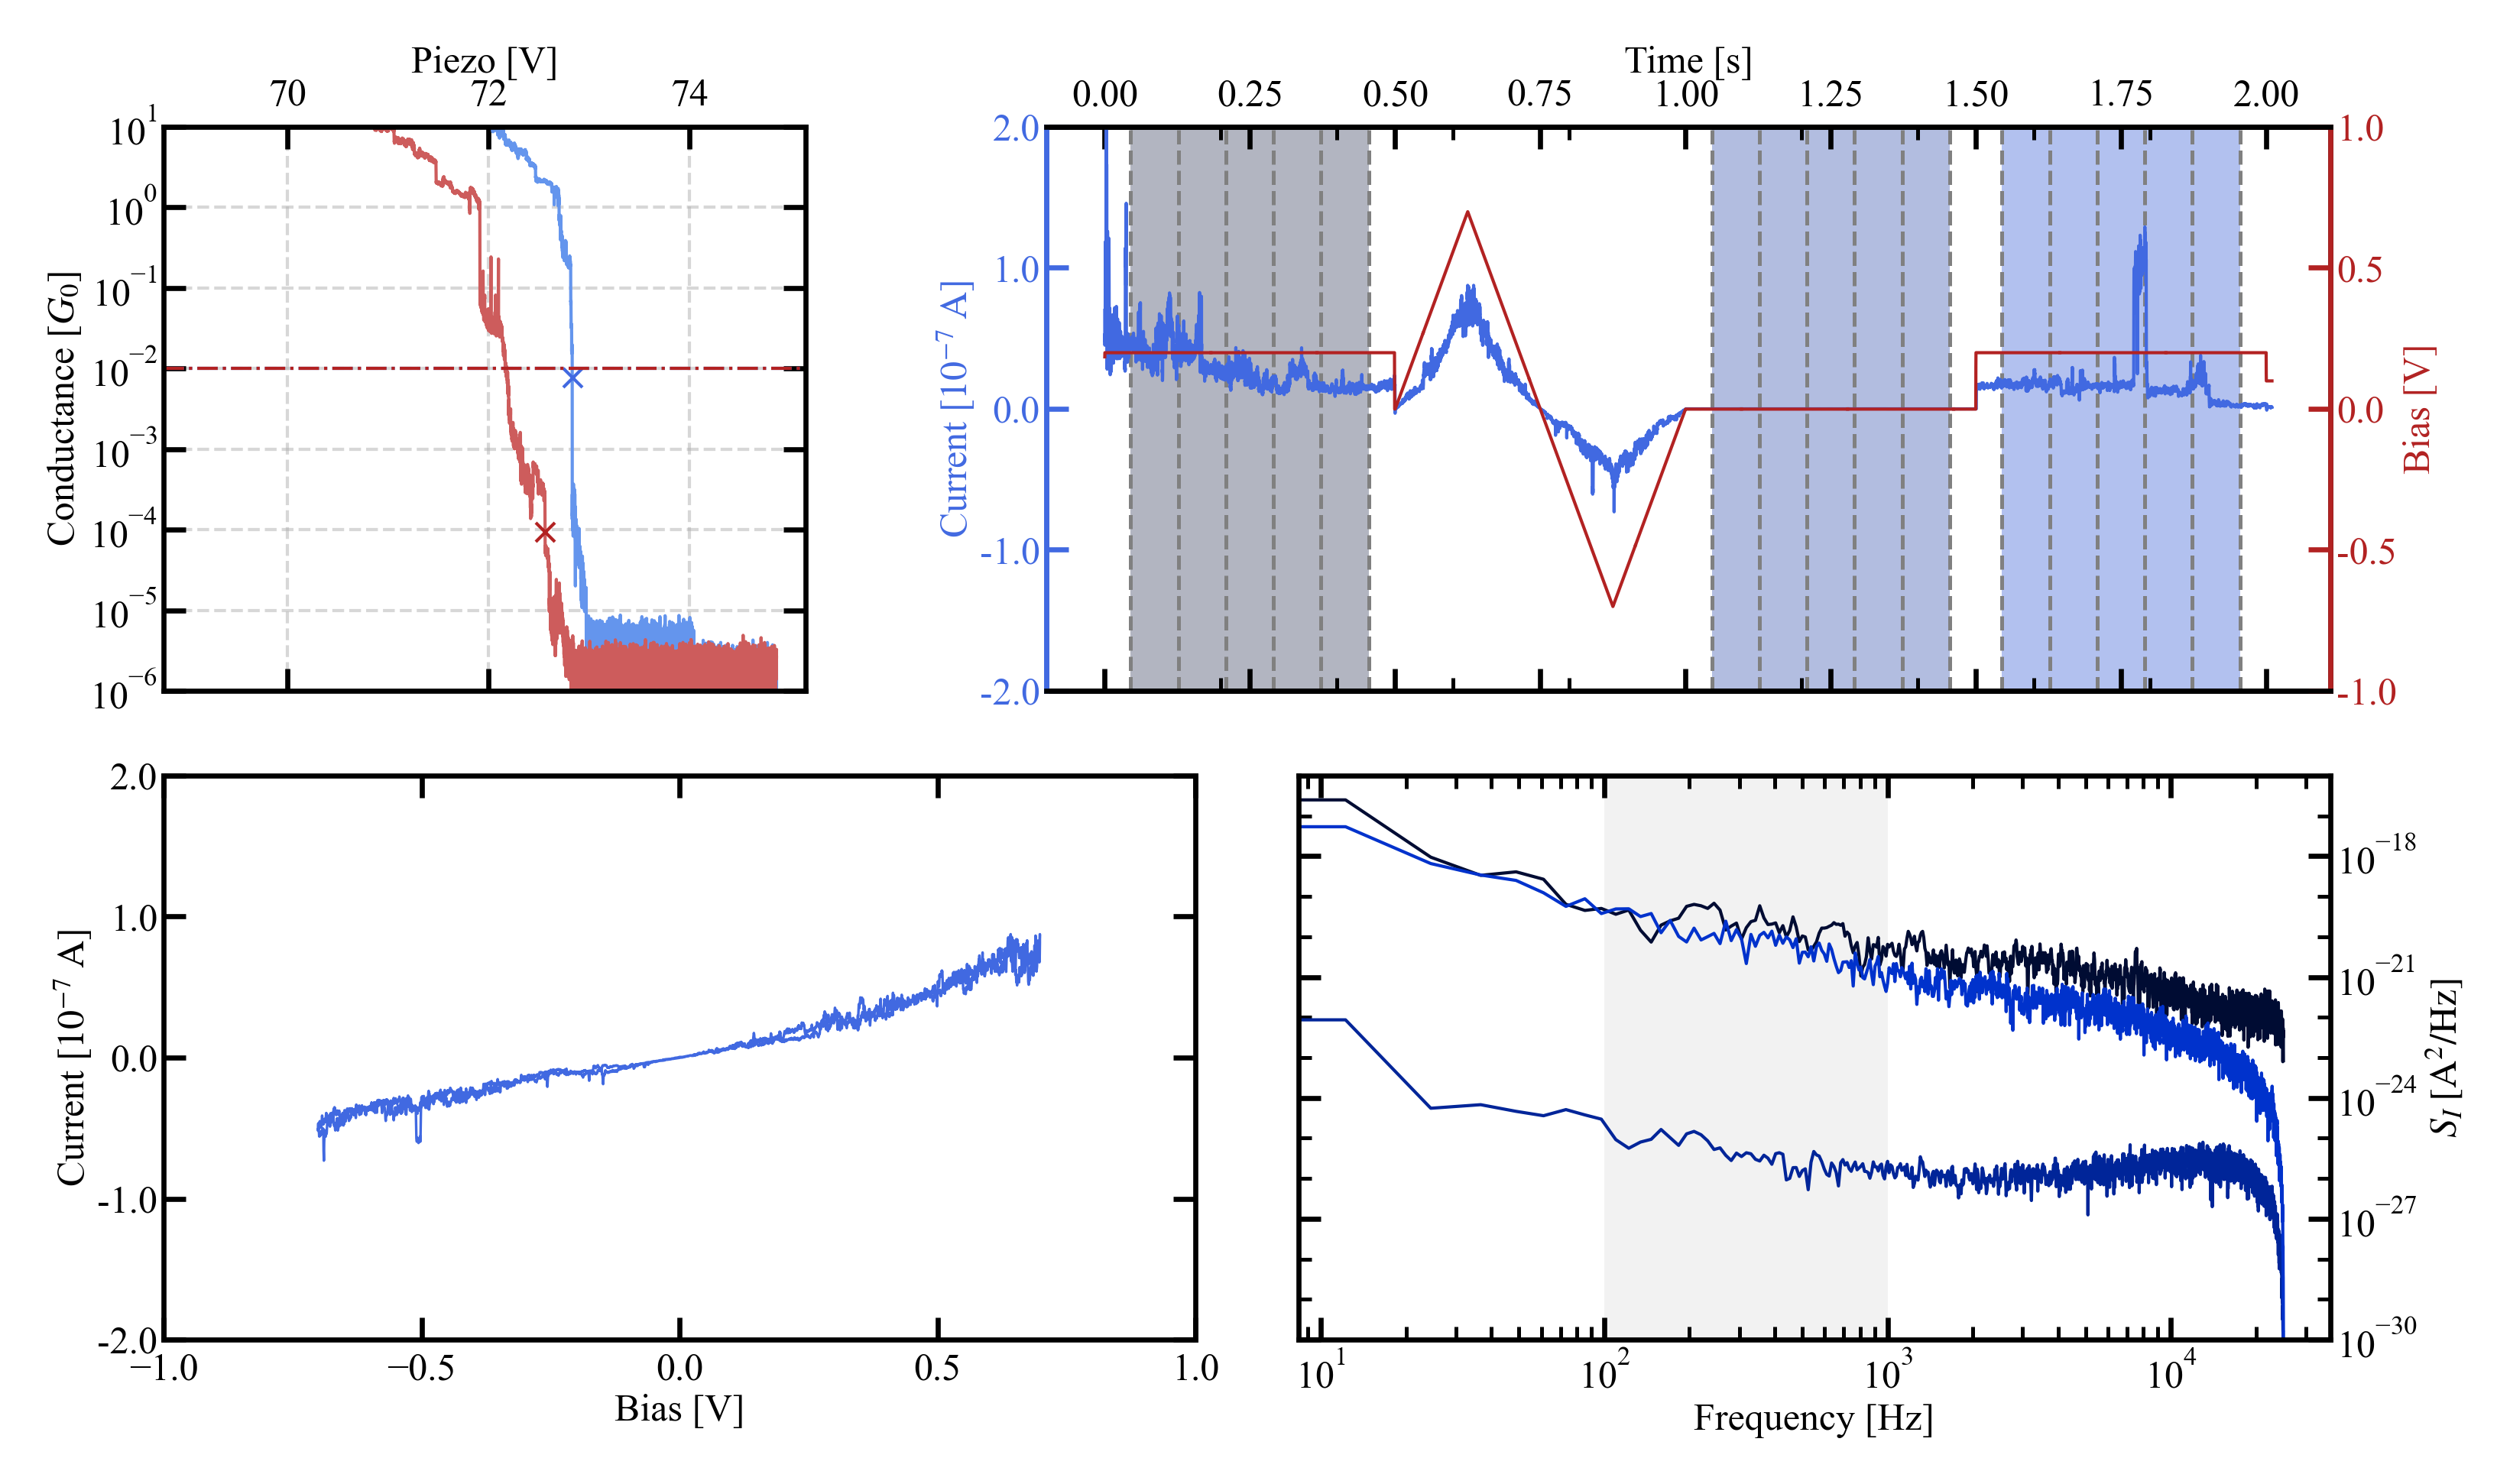

In [9]:
which_trace = stable_pull[0]

hold_trace = HoldTrace(which_trace,
                       load_from=home_folder, bias_offset=0,
                       r_serial_ohm=99_900, min_step_len=20_000, min_height=1, iv=0)

trace_pair = TracePair(which_trace, load_from=home_folder)

hold_trace.analyse_hold_trace(num_of_fft=5, subtract_bg=False)

plots.plot_ivs_scheme_one(trace_pair=trace_pair, hold_trace=hold_trace, direction='pull',
                         smoothing=10, which_psds=[0, 1, 2])

print(filter_traces.iv_difference(hold_trace, direction='pull', smoothing=100))

1.184932335801454


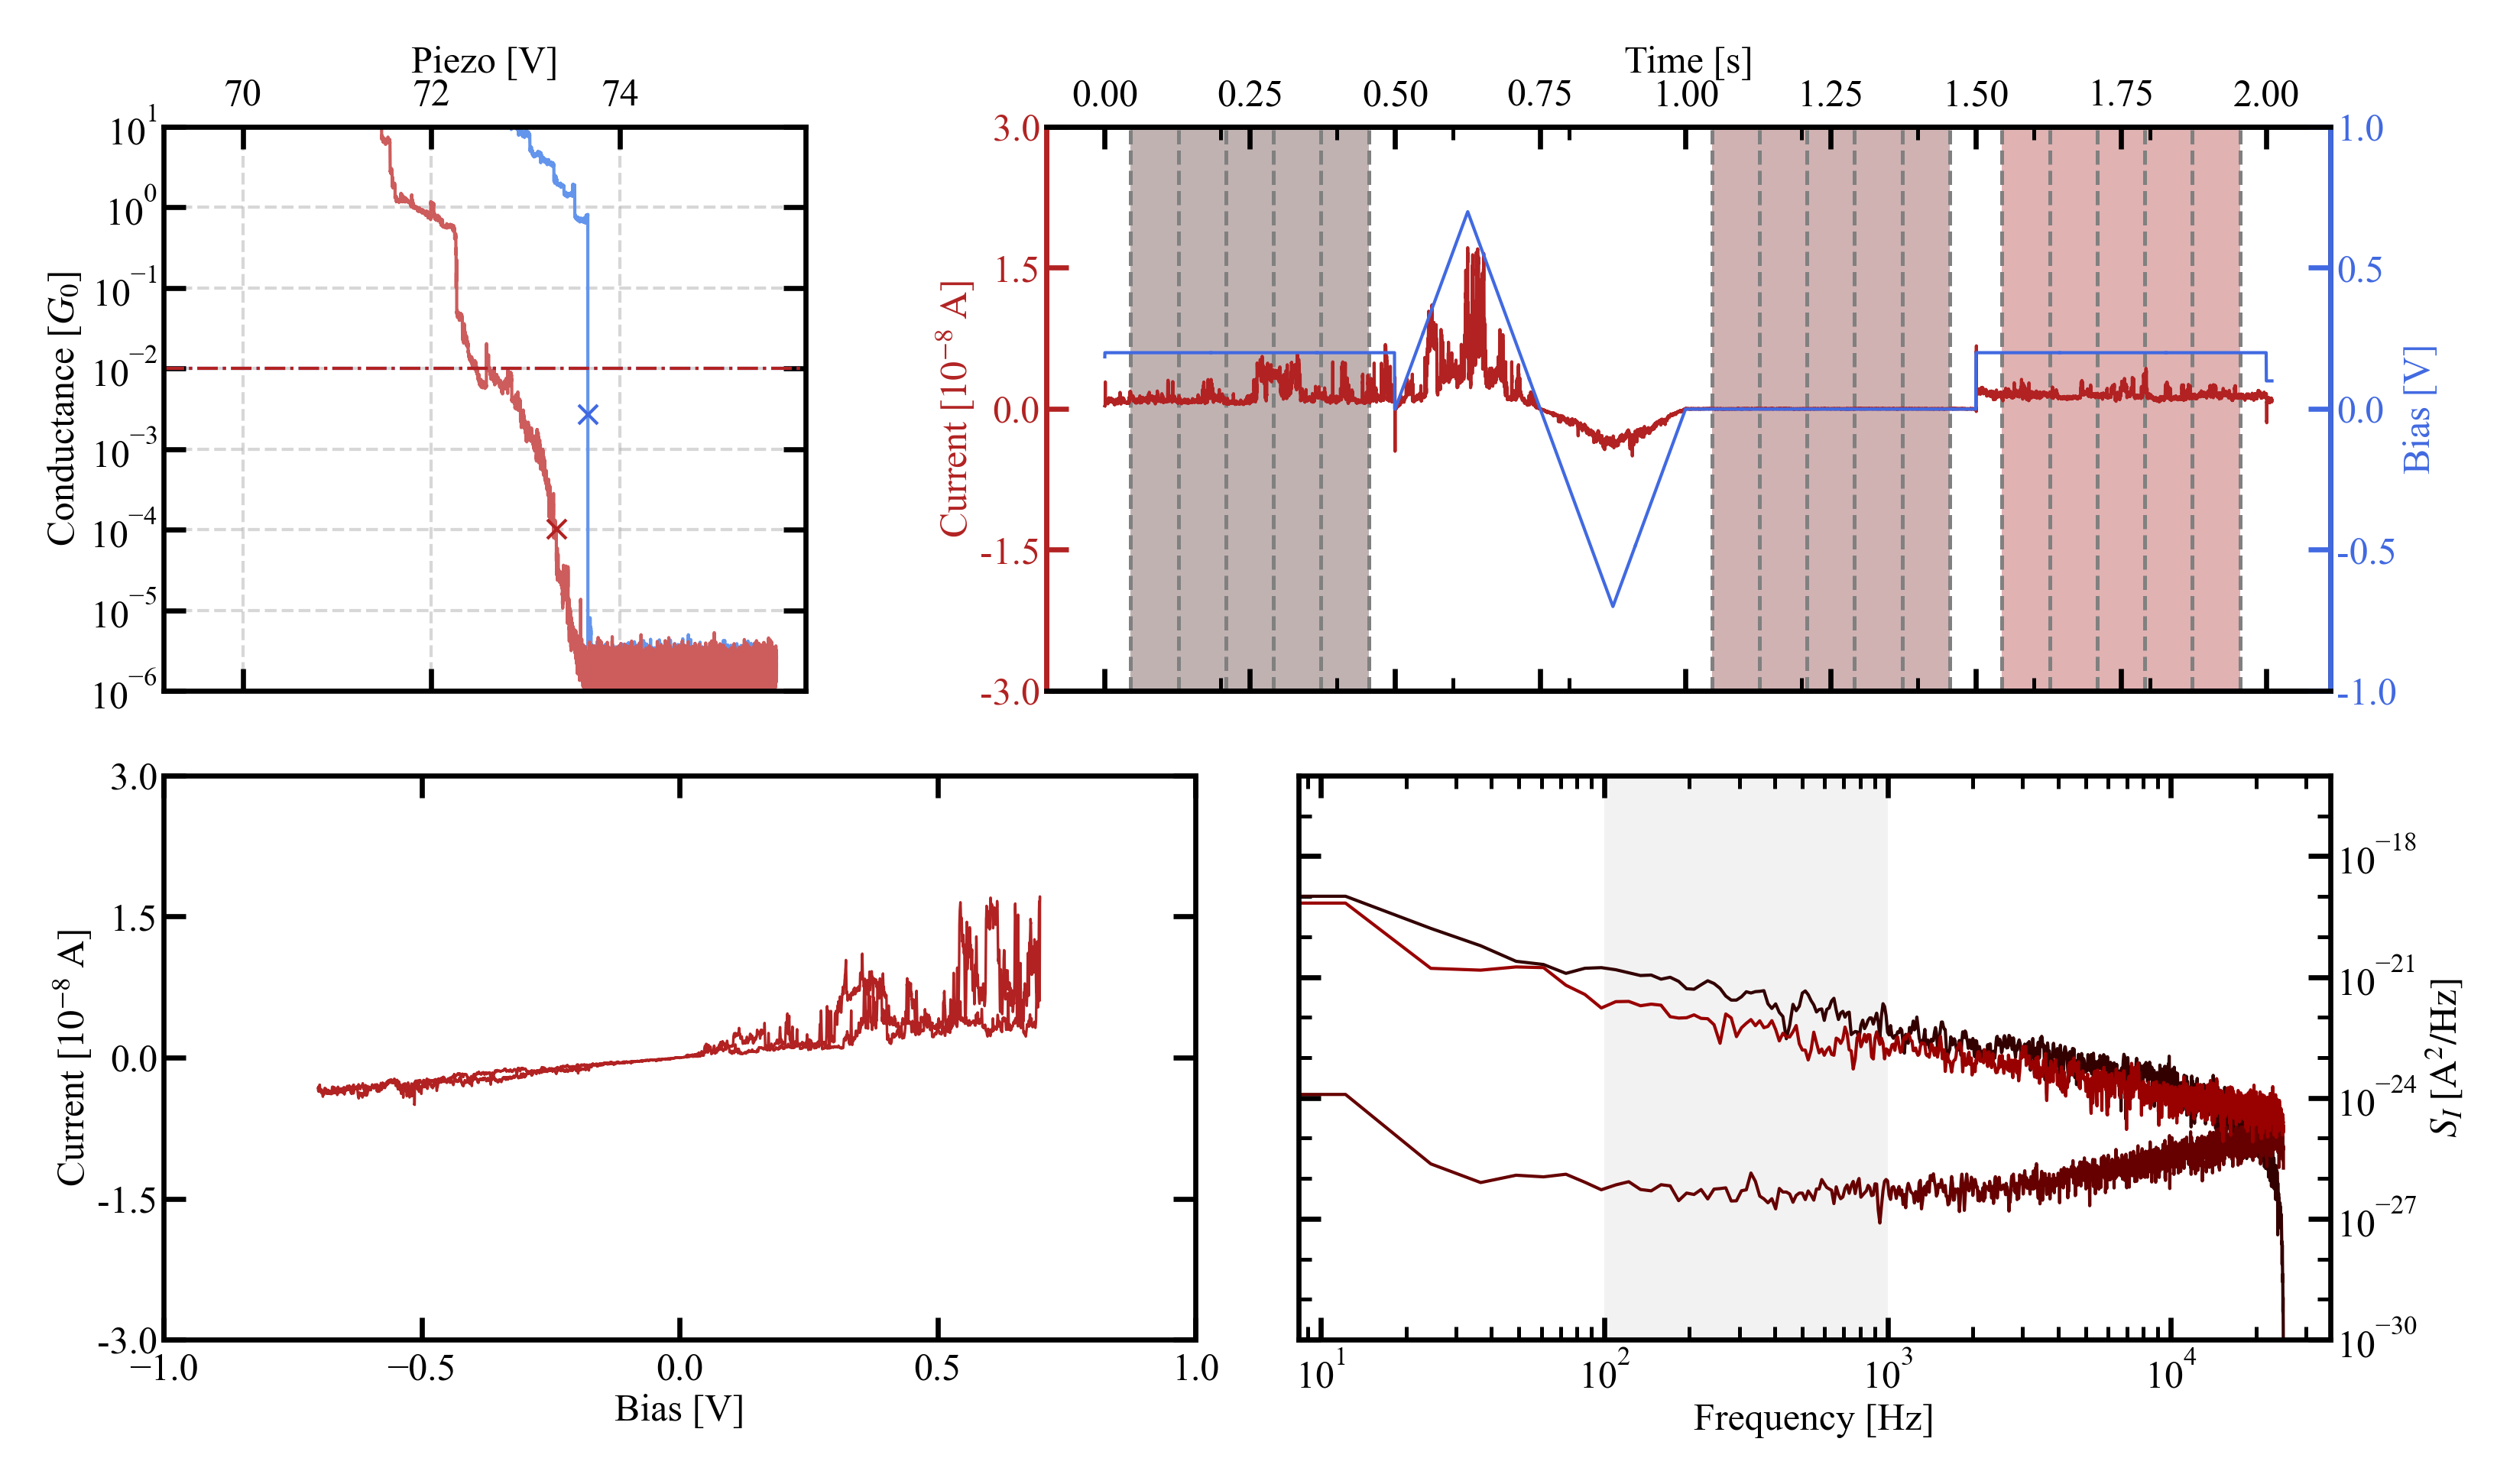

In [10]:
which_trace = stable_push[5]

hold_trace = HoldTrace(which_trace,
                       load_from=home_folder, bias_offset=0,
                       r_serial_ohm=99_900, min_step_len=20_000, min_height=1, iv=0)

trace_pair = TracePair(which_trace, load_from=home_folder)

hold_trace.analyse_hold_trace(num_of_fft=5, subtract_bg=False)

plots.plot_ivs_scheme_one(trace_pair=trace_pair, hold_trace=hold_trace, direction='push',
                         smoothing=10, which_psds=[0, 1, 2])

print(filter_traces.iv_difference(hold_trace, direction='push', smoothing=100))

In [11]:
def get_iv_diff(trace: int, direction: str):
    try:
        hold_trace = HoldTrace(trace, load_from=home_folder, bias_offset=0,
                               r_serial_ohm=100_000, min_step_len=20_000, min_height=1, iv=0)
        # push_diff.append(filter_traces.iv_difference(hold_trace, direction='push', smoothing=100))
        # traces.append(hold_trace.trace_num)
        return filter_traces.iv_difference(hold_trace, direction=direction, smoothing=100)
    except MeasurementOverflow:
        return -1

In [22]:
push_diff = np.array(list(map(get_iv_diff, stable_push, ['push']*len(stable_push))))

In [23]:
pull_diff = np.array(list(map(get_iv_diff, stable_pull, ['pull']*len(stable_pull))))

6832 32.45143209993825


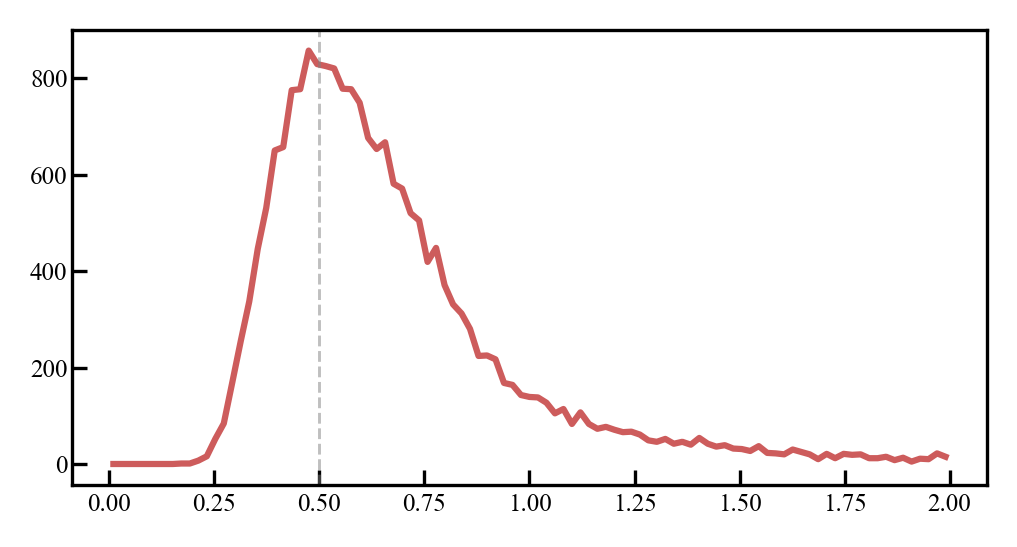

In [24]:
push_diff_bins, push_diff_hist = utils.calc_hist_1d_single(data=push_diff, xrange=(0, 2),
                                                           xbins_num=100, log_scale=False)

print(len(push_diff[push_diff < 0.5]), len(push_diff[push_diff < 0.5])/len(push_diff)*100)

fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 5), dpi=300)
ax.plot(push_diff_bins, push_diff_hist, 'indianred')
ax.axvline(0.5, c='grey', alpha=0.5, ls='--', lw=0.7)

2788 34.30540174726221


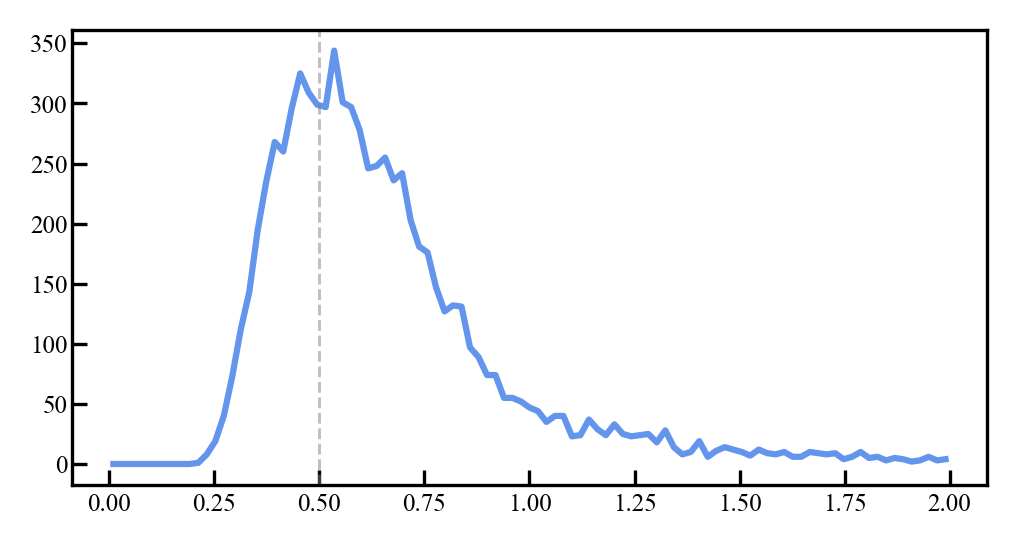

In [25]:
pull_diff_bins, pull_diff_hist = utils.calc_hist_1d_single(data=pull_diff, xrange=(0, 2),
                                                           xbins_num=100, log_scale=False)

print(len(pull_diff[pull_diff < 0.5]), len(pull_diff[pull_diff < 0.5])/len(pull_diff)*100)

fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 5), dpi=300)
ax.plot(pull_diff_bins, pull_diff_hist, 'cornflowerblue')
ax.axvline(0.5, c='grey', alpha=0.5, ls='--', lw=0.7)

In [12]:
# iv_good_push = stable_push[np.where(np.logical_and(push_diff > 0, push_diff < 0.5))[0]]
# iv_good_pull = stable_pull[np.where(np.logical_and(pull_diff > 0, pull_diff < 0.5))[0]]

# with open(home_folder.joinpath('results/iv_good_pull.npy'), 'wb') as f:
#     np.save(f, iv_good_pull)
    
# with open(home_folder.joinpath('results/iv_good_push.npy'), 'wb') as f:
#     np.save(f, iv_good_push)

In [13]:
with open(home_folder.joinpath('results/iv_good_pull.npy'), 'rb') as f:
    iv_good_pull = np.load(f)
    
with open(home_folder.joinpath('results/iv_good_push.npy'), 'rb') as f:
    iv_good_push = np.load(f)

In [14]:
print(f'pull: {len(iv_good_pull)}, {len(iv_good_pull)/total_num*100}%')
print(f'push: {len(iv_good_push)}, {len(iv_good_push)/total_num*100}%')

pull: 2514, 8.522033898305084%
push: 6219, 21.08135593220339%


In [15]:
iv_good_pull

array([19522, 19811, 19877, ..., 48837, 48909, 49042])

0.4974251800322395


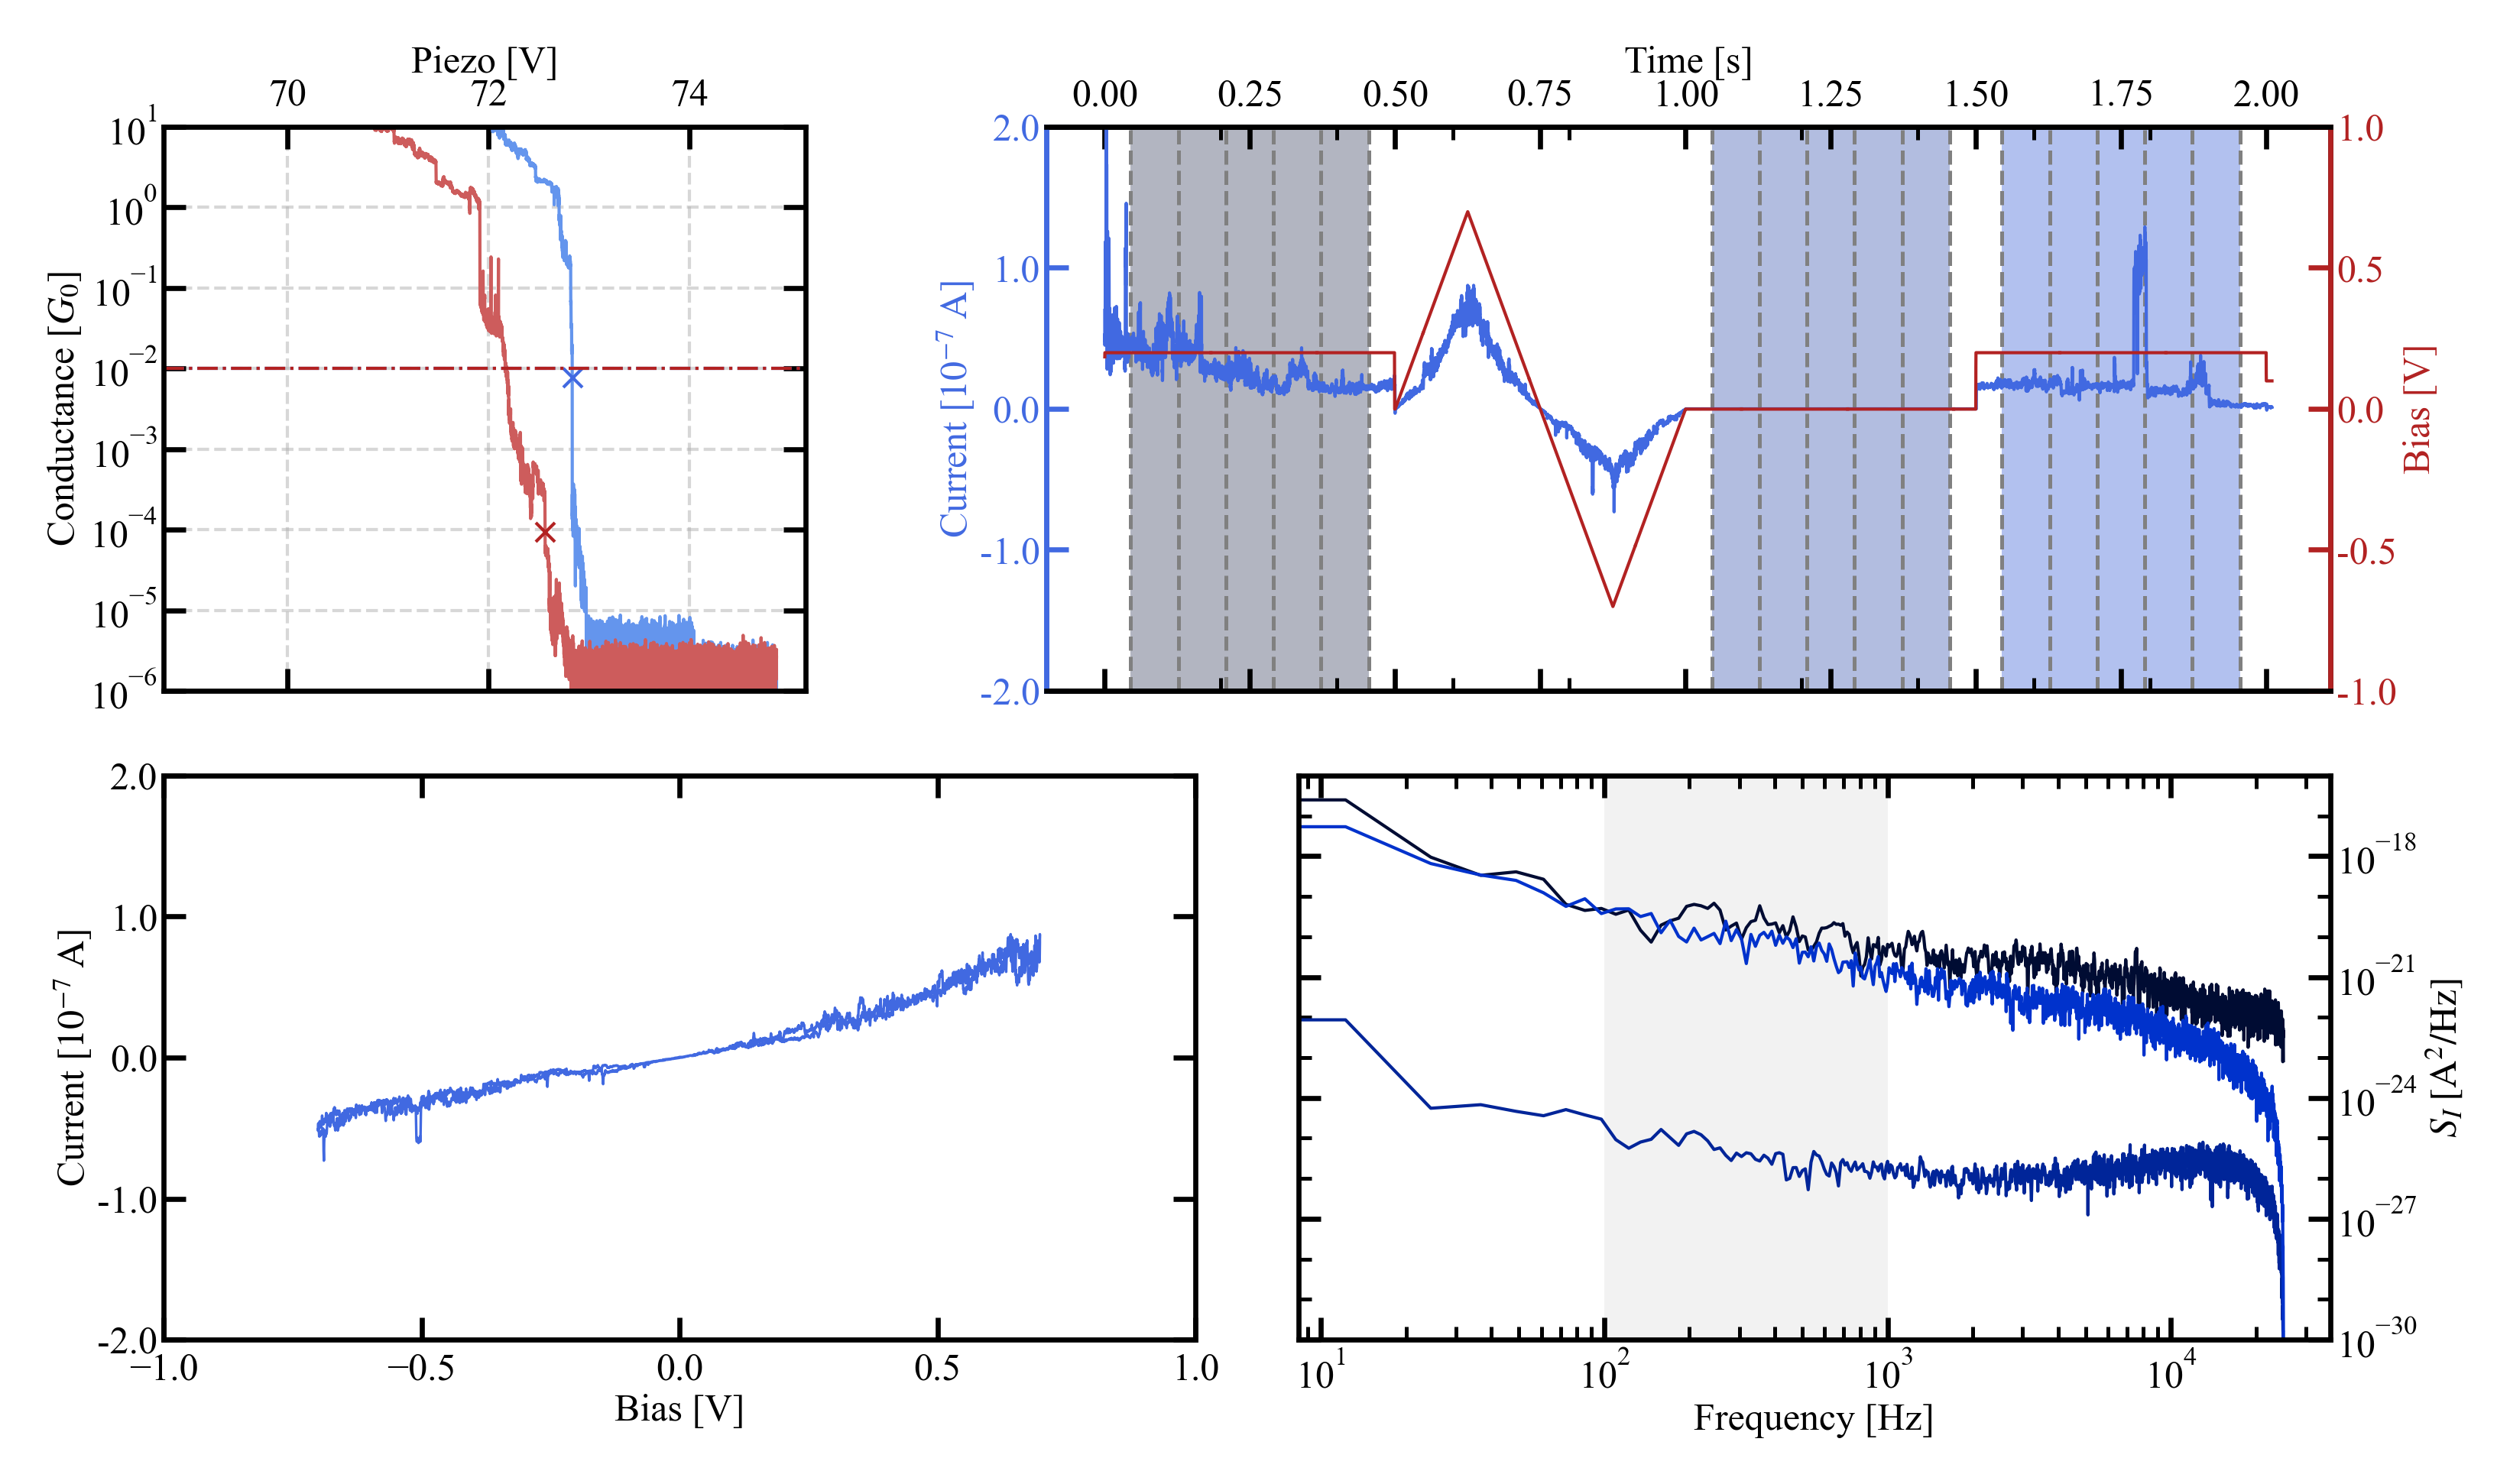

In [16]:
which_trace = iv_good_pull[0]

hold_trace = HoldTrace(which_trace,
                       load_from=home_folder, bias_offset=0,
                       r_serial_ohm=99_900, min_step_len=20_000, min_height=1, iv=0)

trace_pair = TracePair(which_trace, load_from=home_folder)

hold_trace.analyse_hold_trace(num_of_fft=5, subtract_bg=False)

ax_trace, ax_hold, par_hold, ax_iv, ax_psd = plots.plot_ivs_scheme_one(trace_pair=trace_pair, hold_trace=hold_trace, direction='pull',
                                                                       smoothing=10, which_psds=[0, 1, 2])

# ax_iv.set_ylim(-1e-7, 1e-7, 1)
print(filter_traces.iv_difference(hold_trace, direction='pull', smoothing=100))

0.4604861797510561


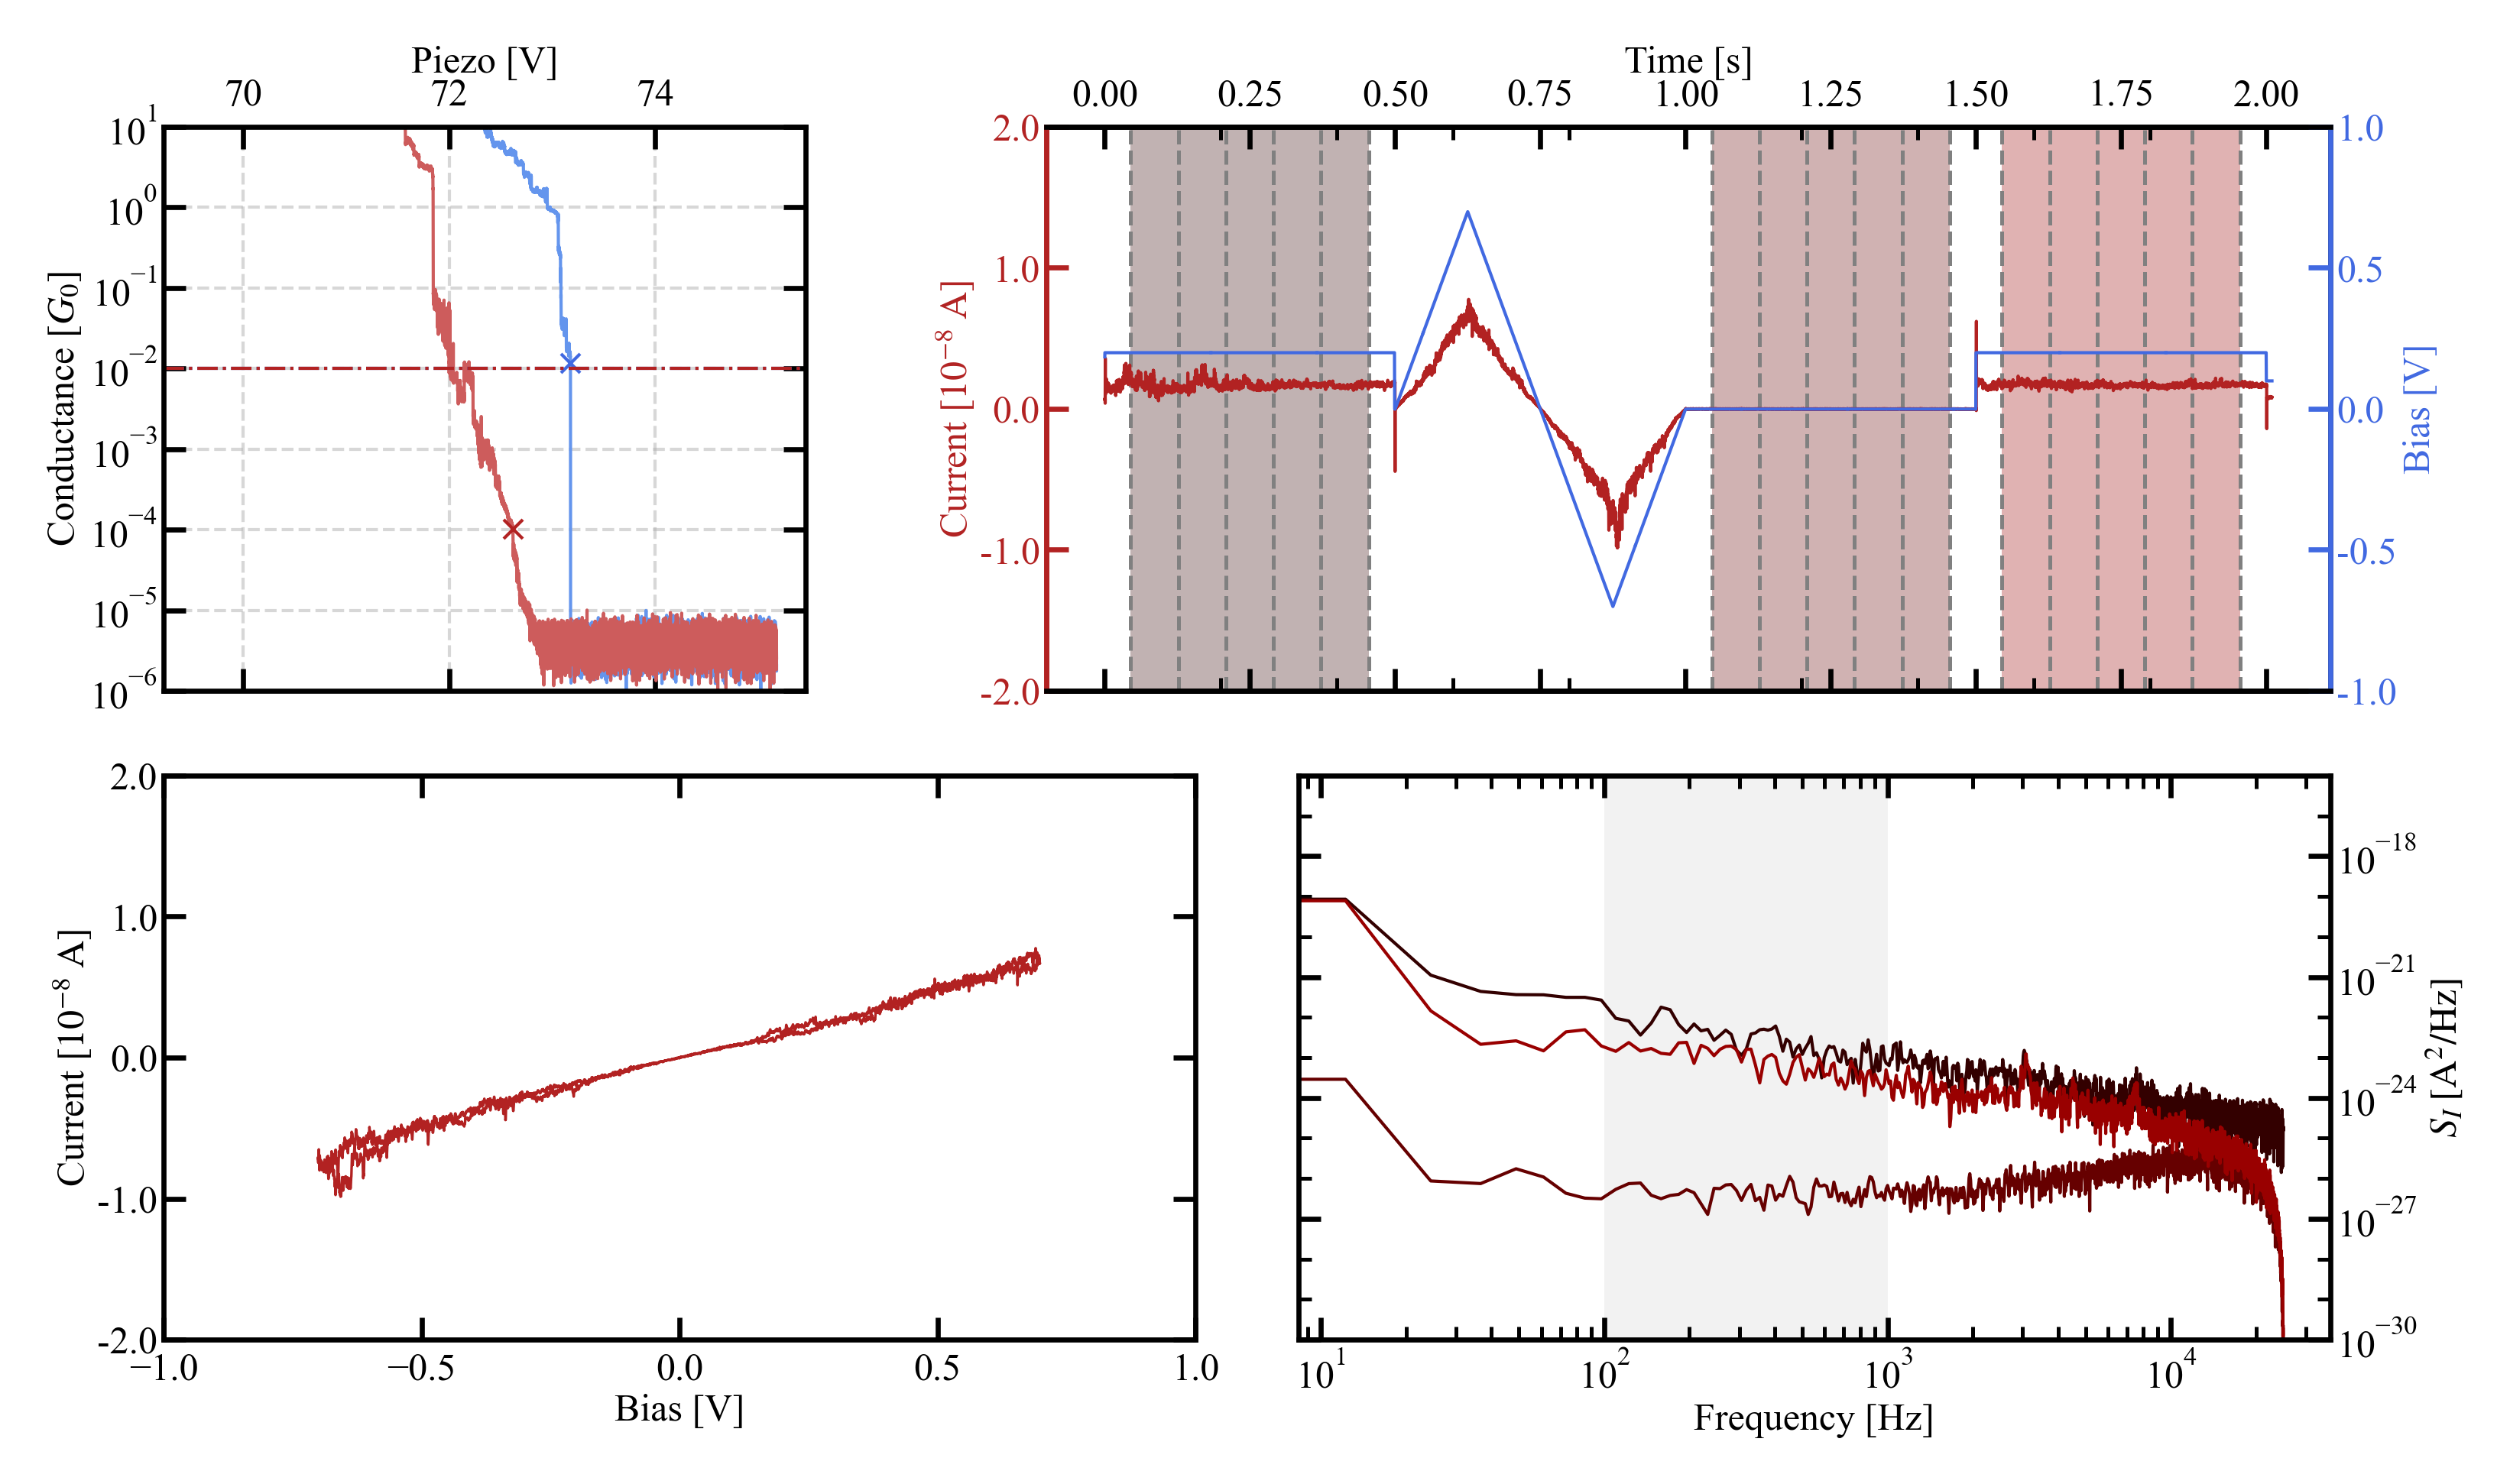

In [17]:
which_trace = iv_good_push[0]

hold_trace = HoldTrace(which_trace,
                       load_from=home_folder, bias_offset=0,
                       r_serial_ohm=99_900, min_step_len=20_000, min_height=1, iv=0)

trace_pair = TracePair(which_trace, load_from=home_folder)

hold_trace.analyse_hold_trace(num_of_fft=5, subtract_bg=True)

plots.plot_ivs_scheme_one(trace_pair=trace_pair, hold_trace=hold_trace, direction='push',
                          smoothing=10, which_psds=[0, 1, 2])

print(filter_traces.iv_difference(hold_trace, direction='push', smoothing=100))

In [18]:
hold_trace.__dict__

{'bias_offset': 0,
 'R_ser': 99900,
 'sample_rate': 50000,
 'gain': 10000000.0,
 'r0': 12900,
 'g0': 7.751937984496124e-05,
 'time_axis_pull': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 2.00996e+00,
        2.00998e+00, 2.01000e+00]),
 'time_axis_push': array([9.00000e-05, 1.10000e-04, 1.30000e-04, ..., 2.00987e+00,
        2.00989e+00, 2.00991e+00]),
 'hold_current_pull': array([ 9.3323010e-08,  1.0087707e-07,  1.0392387e-07, ...,
        -6.4191243e-12, -8.5172078e-12, -3.3312741e-11], dtype=float32),
 'hold_bias_pull': array([0.09999733, 0.09999733, 0.19875221, ..., 0.09874611, 0.09874611,
        0.09874611], dtype=float32),
 'hold_conductance_pull': array([1.32768160e-02, 1.44719576e-02, 7.11693118e-03, ...,
        8.38576518e-07, 1.11266197e-06, 4.35176545e-06]),
 'hold_current_push': array([5.2477744e-10, 6.0889155e-10, 7.3420436e-10, ..., 7.6739221e-10,
        7.9533485e-10, 8.5369972e-10], dtype=float32),
 'hold_bias_push': array([0.09999733, 0.14937477, 0.19875221, 

In [19]:
hold_set_pull = np.zeros(iv_good_pull.shape[0])
hold_conductance_pull = np.zeros(iv_good_pull.shape[0])
# areas_under_psd_pull = []
avg_cond_on_step_pull = []
noise_power_pull = []
conductance_noise_pull = []
current_noise_pull = []

for i, which_trace in enumerate(tqdm(iv_good_pull)):
    trace_pair = TracePair(which_trace, load_from=home_folder)
    hold_trace = HoldTrace(which_trace,
                           load_from=home_folder, bias_offset=0,
                           r_serial_ohm=99_900, min_step_len=20_000, min_height=1, iv=0)
    hold_trace.analyse_hold_trace(num_of_fft=5, subtract_bg=True)
    
    hold_trace.save_iv_for_laci(home_folder=home_folder, direction='pull')

    hold_set_pull[i] = trace_pair.hold_set_pull
    hold_conductance_pull[i] = trace_pair.hold_conductance_pull
    # areas_under_psd_pull.append(hold_trace.areas_pull)
    avg_cond_on_step_pull.append(hold_trace.avg_cond_on_step_pull)
    noise_power_pull.append(hold_trace.noise_power_pull)
    conductance_noise_pull.append(hold_trace.conductance_noise_pull)
    current_noise_pull.append(hold_trace.current_noise_pull)
    
# areas_under_psd_pull = np.array(areas_under_psd_pull)
avg_cond_on_step_pull = np.array(avg_cond_on_step_pull)
noise_power_pull = np.array(noise_power_pull)
conductance_noise_pull = np.array(conductance_noise_pull)
current_noise_pull = np.array(current_noise_pull)

  0%|          | 0/2514 [00:00<?, ?it/s]

In [20]:
np.unique(avg_cond_on_step_pull[:, 0]/avg_cond_on_step_pull[:, 1] < 2, return_counts=True)

(array([False,  True]), array([ 696, 1818], dtype=int64))

In [23]:
print(conductance_noise_pull)
print('****')
print(current_noise_pull)

[[0.08579586 0.14368053]
 [0.10728864 0.04385119]
 [0.03529307 0.02556574]
 ...
 [0.07371972 0.05069521]
 [0.03771861 0.05034934]
 [0.03249341 0.02173377]]
****
[[0.08777209 0.14496613]
 [0.11149637 0.04477874]
 [0.03708981 0.02636386]
 ...
 [0.07500189 0.05126414]
 [0.03783791 0.05041196]
 [0.03274549 0.02186173]]


In [21]:
hold_set_push = np.zeros(iv_good_push.shape[0])
hold_conductance_push = np.zeros(iv_good_push.shape[0])
# areas_under_psd_push = []
avg_cond_on_step_push = []
noise_power_push = []
conductance_noise_push = []
current_noise_push = []

for i, which_trace in enumerate(tqdm(iv_good_push)):
    trace_pair = TracePair(which_trace, load_from=home_folder)
    hold_trace = HoldTrace(which_trace,
                           load_from=home_folder, bias_offset=0,
                           r_serial_ohm=99_900, min_step_len=20_000, min_height=1, iv=0)
    hold_trace.analyse_hold_trace(num_of_fft=5, subtract_bg=True)
    
    hold_trace.save_iv_for_laci(home_folder=home_folder, direction='push')

    hold_set_push[i] = trace_pair.hold_set_push
    hold_conductance_push[i] = trace_pair.hold_conductance_push
    # areas_under_psd_push.append(hold_trace.areas_push)
    avg_cond_on_step_push.append(hold_trace.avg_cond_on_step_push)
    noise_power_push.append(hold_trace.noise_power_push)
    conductance_noise_push.append(hold_trace.conductance_noise_push)
    current_noise_push.append(hold_trace.current_noise_push)
    
# areas_under_psd_push = np.array(areas_under_psd_push)
avg_cond_on_step_push = np.array(avg_cond_on_step_push)
noise_power_push = np.array(noise_power_push)
conductance_noise_push = np.array(conductance_noise_push)
current_noise_push = np.array(current_noise_push)

  0%|          | 0/6219 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 0, '$\\langle G \\rangle\\;[G_{0}]$')

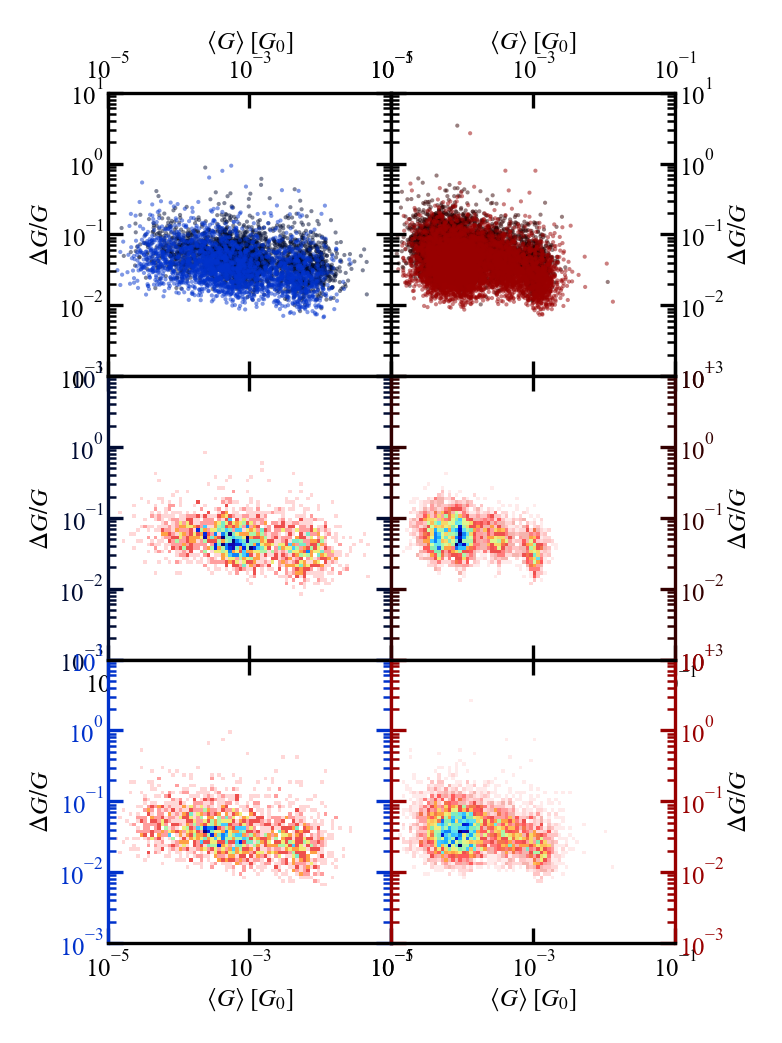

In [118]:
fig = plt.figure(figsize=utils.cm2inch(6, 9), dpi=300)  # figsize: (width, height) in inches

gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=(1, 1),
                       figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0, hspace=0)

ax_pull = fig.add_subplot(gs[0, 0])
ax_push = fig.add_subplot(gs[0, 1], sharey=ax_pull)

ax_pull_2d_1 = fig.add_subplot(gs[1, 0], sharex=ax_pull)
ax_push_2d_1 = fig.add_subplot(gs[1, 1], sharey=ax_pull, sharex=ax_push)

ax_pull_2d_2 = fig.add_subplot(gs[2, 0], sharex=ax_pull)
ax_push_2d_2 = fig.add_subplot(gs[2, 1], sharey=ax_pull, sharex=ax_push)

x_mesh_pull, y_mesh_pull, hist_2d_pull_1 = utils.calc_hist_2d_single(x=avg_cond_on_step_pull[:, 0],
                                                                     y=conductance_noise_pull[:, 0],
                                                                     xrange=(1e-5, 1e-1), log_scale_x=True,
                                                                     yrange=(1e-3, 10), log_scale_y=True,
                                                                     num_bins=(20, 20),
                                                                     bin_mode_x='decade',
                                                                     bin_mode_y='decade')

x_mesh_push, y_mesh_push, hist_2d_push_1 = utils.calc_hist_2d_single(x=avg_cond_on_step_push[:, 0],
                                                                     y=conductance_noise_push[:, 0],
                                                                     xrange=(1e-5, 1e-1), log_scale_x=True,
                                                                     yrange=(1e-3, 10), log_scale_y=True,
                                                                     num_bins=(20, 20),
                                                                     bin_mode_x='decade',
                                                                     bin_mode_y='decade')

x_mesh_pull, y_mesh_pull, hist_2d_pull_2 = utils.calc_hist_2d_single(x=avg_cond_on_step_pull[:, 1],
                                                                     y=conductance_noise_pull[:, 1],
                                                                     xrange=(1e-5, 1e-1), log_scale_x=True,
                                                                     yrange=(1e-3, 10), log_scale_y=True,
                                                                     num_bins=(20, 20),
                                                                     bin_mode_x='decade',
                                                                     bin_mode_y='decade')

x_mesh_push, y_mesh_push, hist_2d_push_2 = utils.calc_hist_2d_single(x=avg_cond_on_step_push[:, 1],
                                                                     y=conductance_noise_push[:, 1],
                                                                     xrange=(1e-5, 1e-1), log_scale_x=True,
                                                                     yrange=(1e-3, 10), log_scale_y=True,
                                                                     num_bins=(20, 20),
                                                                     bin_mode_x='decade',
                                                                     bin_mode_y='decade')

ax_pull.xaxis.set_label_position('top')
ax_pull.xaxis.tick_top()
ax_pull.xaxis.set_ticks_position('both')
ax_pull.yaxis.set_ticks_position('both')
ax_push.xaxis.set_label_position('top')
ax_push.xaxis.tick_top()
ax_push.yaxis.set_label_position('right')
ax_push.yaxis.tick_right()
ax_push.xaxis.set_ticks_position('both')
ax_push.yaxis.set_ticks_position('both')

ax_pull_2d_1.xaxis.set_ticks_position('both')
ax_pull_2d_1.yaxis.set_ticks_position('both')
ax_push_2d_1.yaxis.set_label_position('right')
ax_push_2d_1.yaxis.tick_right()
ax_push_2d_1.xaxis.set_ticks_position('both')
ax_push_2d_1.yaxis.set_ticks_position('both')

ax_pull_2d_2.xaxis.set_ticks_position('both')
ax_pull_2d_2.yaxis.set_ticks_position('both')
ax_push_2d_2.yaxis.set_label_position('right')
ax_push_2d_2.yaxis.tick_right()
ax_push_2d_2.xaxis.set_ticks_position('both')
ax_push_2d_2.yaxis.set_ticks_position('both')

ax_pull.scatter(avg_cond_on_step_pull[:, 0], conductance_noise_pull[:, 0], alpha=0.5, c=utils.blues[0], edgecolor='None', s=1)
ax_pull.scatter(avg_cond_on_step_pull[:, 1], conductance_noise_pull[:, 1], alpha=0.5, c=utils.blues[2], edgecolor='None', s=1)
ax_pull.set_xscale('log')
ax_pull.set_yscale('log')

ax_push.scatter(avg_cond_on_step_push[:, 0], conductance_noise_push[:, 0], alpha=0.5, c=utils.reds[0], edgecolor='None', s=1)
ax_push.scatter(avg_cond_on_step_push[:, 1], conductance_noise_push[:, 1], alpha=0.5, c=utils.reds[2], edgecolor='None', s=1)
ax_push.set_xscale('log')
ax_push.set_yscale('log')

im_norm_pull = ax_pull_2d_1.pcolormesh(x_mesh_pull, y_mesh_pull, hist_2d_pull_1, cmap=utils.cmap_geo32)
ax_pull_2d_1.set_xscale('log')
ax_pull_2d_1.set_yscale('log')
im_norm_push = ax_push_2d_1.pcolormesh(x_mesh_push, y_mesh_push, hist_2d_push_1, cmap=utils.cmap_geo32)
ax_push_2d_1.set_xscale('log')
ax_push_2d_1.set_yscale('log')

im_norm_pull = ax_pull_2d_2.pcolormesh(x_mesh_pull, y_mesh_pull, hist_2d_pull_2, cmap=utils.cmap_geo32)
ax_pull_2d_2.set_xscale('log')
ax_pull_2d_2.set_yscale('log')
im_norm_push = ax_push_2d_2.pcolormesh(x_mesh_push, y_mesh_push, hist_2d_push_2, cmap=utils.cmap_geo32)
ax_push_2d_2.set_xscale('log')
ax_push_2d_2.set_yscale('log')

# ax.spines['bottom'].set_color('#dddddd')
# ax.spines['top'].set_color('#dddddd') 
ax_pull_2d_1.spines['right'].set_color(utils.blues[0])
ax_pull_2d_1.spines['left'].set_color(utils.blues[0])
ax_pull_2d_1.tick_params(axis='y', which='both', colors=utils.blues[0])
ax_pull_2d_2.spines['right'].set_color(utils.blues[2])
ax_pull_2d_2.spines['left'].set_color(utils.blues[2])
ax_pull_2d_2.tick_params(axis='y', which='both', colors=utils.blues[2])

ax_push_2d_1.spines['right'].set_color(utils.reds[0])
ax_push_2d_1.spines['left'].set_color(utils.reds[0])
ax_push_2d_1.tick_params(axis='y', which='both', colors=utils.reds[0])
ax_push_2d_2.spines['right'].set_color(utils.reds[2])
ax_push_2d_2.spines['left'].set_color(utils.reds[2])
ax_push_2d_2.tick_params(axis='y', which='both', colors=utils.reds[2])

ax_pull.set_ylabel(r'$\Delta G / G$')
ax_pull_2d_1.set_ylabel(r'$\Delta G / G$')
ax_pull_2d_2.set_ylabel(r'$\Delta G / G$')

ax_pull.set_xlabel(r'$\langle G \rangle\;[G_{0}]$')
ax_pull_2d_2.set_xlabel(r'$\langle G \rangle\;[G_{0}]$')

ax_push.set_ylabel(r'$\Delta G / G$')
ax_push_2d_1.set_ylabel(r'$\Delta G / G$')
ax_push_2d_2.set_ylabel(r'$\Delta G / G$')

ax_push.set_xlabel(r'$\langle G \rangle\;[G_{0}]$')
ax_push_2d_2.set_xlabel(r'$\langle G \rangle\;[G_{0}]$')

In [129]:
noise_data_pull = pd.DataFrame(data={
                               'trace_index': iv_good_pull,
                               'avg_cond_1': avg_cond_on_step_pull[:, 0],
                               'noise_power_1' : noise_power_pull[:, 0],
                               'conductance_noise_1' : conductance_noise_pull[:, 0],
                               'current_noise_1' : current_noise_pull[:, 0],
                               'avg_cond_2': avg_cond_on_step_pull[:, 1],
                               'noise_power_2' : noise_power_pull[:, 1],
                               'conductance_noise_2' : conductance_noise_pull[:, 1],
                               'current_noise_2' : current_noise_pull[:, 1]})

In [125]:
noise_data_push = pd.DataFrame(data={
                               'trace_index': iv_good_push,
                               'avg_cond_1': avg_cond_on_step_push[:, 0],
                               'noise_power_1' : noise_power_push[:, 0],
                               'conductance_noise_1' : conductance_noise_push[:, 0],
                               'current_noise_1' : current_noise_push[:, 0],
                               'avg_cond_2': avg_cond_on_step_push[:, 1],
                               'noise_power_2' : noise_power_push[:, 1],
                               'conductance_noise_2' : conductance_noise_push[:, 1],
                               'current_noise_2' : current_noise_push[:, 1]})

In [130]:
noise_data_pull

,trace_index,avg_cond_1,noise_power_1,conductance_noise_1,current_noise_1,avg_cond_2,noise_power_2,conductance_noise_2,current_noise_2
0,19522,0.002974,6.512103e-08,0.085796,0.087772,0.001155,2.755858e-08,0.143681,0.144966
1,19811,0.005064,2.952176e-07,0.107289,0.111496,0.002731,1.434570e-08,0.043851,0.044779
2,19877,0.006574,5.382957e-08,0.035293,0.037090,0.004031,1.062155e-08,0.025566,0.026364
3,19905,0.011038,3.772239e-07,0.055643,0.060399,0.007856,3.376817e-08,0.023391,0.024814
4,19998,0.005919,9.695815e-08,0.052609,0.055020,0.002665,2.075603e-08,0.054060,0.055175
...,...,...,...,...,...,...,...,...,...
2509,48577,0.000793,1.826353e-09,0.053881,0.054212,0.000575,3.808237e-10,0.033965,0.034116
2510,48668,0.000072,1.455683e-10,0.168055,0.168149,0.000056,1.595658e-11,0.071779,0.071810
2511,48837,0.002246,2.741194e-08,0.073720,0.075002,0.001449,5.397214e-09,0.050695,0.051264
2512,48909,0.000408,2.372949e-10,0.037719,0.037838,0.000161,6.537209e-11,0.050349,0.050412


In [131]:
noise_data_pull.to_csv(home_folder.joinpath('results/IVs/selected/noise_data_pull_1.csv'), index=False)

In [132]:
noise_data_push.to_csv(home_folder.joinpath('results/IVs/selected/noise_data_push_1.csv'), index=False)

In [59]:
print(trace_pair.hold_set_push)
print(trace_pair.hold_conductance_push)

0.01
0.000103557504
